# IMPORTS

In [1]:
#importing relevant libraries

import numpy as np 
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit    #for fitting an exponential
import functools as fnt
from textwrap import wrap
import matplotlib.collections as mcoll
import matplotlib.path as mpath

# CONSTANTS

In [2]:
#relevant constants
pc = 3.086e18                   #cm
pi = np.pi
s_to_yr = 3.171e-8               #seconds to years
#galaxy specific constants (taken from SS21_ch11)
R = 10*(10**3)*pc           #radius in cm
# omega = 6.481*(10**(-18))   #angular velocity in s^-1
h = 0.5*(10**3)*pc          #height in cm
eta_T = 10**26              #Diffusion coefficient in cm^2 s^-1
to = h*h/eta_T              #diffusion time in s
to_gyr = round(to*s_to_yr*1e-9, 3)    #diffusion time in Gyr
print("Diffusion timescale to = ", to_gyr, 'Gyr')
print('time stepping is normalised to t_o(s) = ', to, 's')

Diffusion timescale to =  0.755 Gyr
time stepping is normalised to t_o(s) =  2.380849e+16 s


# DIFFERENTIAL EQUATIONS

##### changes made to the differential equations for task 3 :
- made alpha independent of $r$ and dependent on $z$
- instead of passing $R_\alpha$ and $D$ like in task 2, the $B_\phi$ differential equation now depends on $R_\alpha$ and $R_\omega$, and $D$ is calculated as $R_\alpha R_\omega$

In [19]:
def Br_diff(t, Br, Bp, r_ind, dz, alpha):                          #for both alpha-omega and alpha-square omega dynamo

    dBr_dt = np.array(-1*(-3*alpha[0]*Bp[0] + 4*alpha[1]*Bp[1] - alpha[2]*Bp[2])/(2*dz) + (2*Br[0] - 5*Br[1] + 4*Br[2] - Br[3])/(dz**2))                           #for boundary
    dBr_dt = np.append(dBr_dt, -1*np.array(alpha[2:]*Bp[2:] - alpha[:-2]*Bp[:-2])/(2*dz) + np.array(Br[:-2] + Br[2:] - 2*Br[1:-1])/(dz**2))                        #for interior
    dBr_dt = np.append(dBr_dt, -1*(3*alpha[-1]*Bp[-1] - 4*alpha[-2]*Bp[-2] + alpha[-3]*Bp[-3])/(2*dz) + (2*Br[-1] - 5*Br[-2] + 4*Br[-3] - Br[-4])/(dz**2))         #for boundary
    return dBr_dt

def Bp_diff(t, Br, Bp, r_ind, dz, alpha, S, Ralpha, Romega, ao = True):     
    D = Ralpha*Romega
    if ao:          #for alpha-omega dynamo 
        dBp_dt = np.array( D*S[r_ind]*Br[0] + (2*Bp[0] - 5*Bp[1] + 4*Bp[2] - Bp[3])/(dz**2) )                                               #for boundary
        dBp_dt = np.append(dBp_dt, D*S[r_ind]*np.array(Br[1:-1]) + np.array(Bp[:-2] + Bp[2:] - 2*Bp[1:-1])/(dz**2))                         #for interior
        dBp_dt = np.append(dBp_dt, D*S[r_ind]*Br[-1] + (2*Bp[-1] - 5*Bp[-2] + 4*Bp[-3] - Bp[-4])/(dz**2))                                   #for boundary
    else:           #for alpha-square omega dynamo
        dBp_dt = np.array( D*S[r_ind]*Br[0] + (Ralpha**2)*(-3*alpha[0]*Br[0] + 4*alpha[1]*Br[1] - alpha[2]*Br[2])/(2*dz) + (2*Bp[0] - 5*Bp[1] + 4*Bp[2] - Bp[3])/(dz**2))                         #for boundary
        dBp_dt = np.append(dBp_dt, D*S[r_ind]*np.array(Br[1:-1]) + (Ralpha**2)*np.array(alpha[2:]*Br[2:] - alpha[:-2]*Br[:-2])/(2*dz) + np.array(Bp[:-2] + Bp[2:] - 2*Bp[1:-1])/(dz**2))          #for interior
        dBp_dt = np.append(dBp_dt, D*S[r_ind]*Br[-1] + (Ralpha**2)*(3*alpha[-1]*Br[-1] - 4*alpha[-2]*Br[-2] + alpha[-3]*Br[-3])/(2*dz) + (2*Bp[-1] - 5*Bp[-2] + 4*Bp[-3] - Bp[-4])/(dz**2))       #for boundary
    return dBp_dt

def rk4(F, G, X, Y, BX0, BXn, BY0, BYn, t, dt, dz, bc = 'dir'):
    #F is the function for the time evolution of X, in our case Br
    #G is the function for the time evolution of Y, in our case Bp
    #X is the array of X values
    #Y is the array of Y values
    #t is the current time
    #dt is the time step
    #dz is the spatial step
    #bc is the boundary condition type
    #BX0, BY0, BXn, BYn are the boundary values

    #We know the time evolution of the borders
    #So we only need to solve for the interior

    #let len(X) = len(Y) = n
    #Assigning the first boundary value
    if bc == 'dir':
        X_new = np.array([BX0])
        Y_new = np.array([BY0])
    elif bc == 'neu':
        X_new = np.array([4*X[1]/3 - X[2]/3 - 2*dz*BX0/3])
        Y_new = np.array([4*Y[1]/3 - Y[2]/3 - 2*dz*BY0/3])

    #Solving the runge kutta coefficients
    k1 = F(t, X, Y)                                     #len = n
    l1 = G(t, X, Y)                                     #len = n

    k2 = F(t + dt/2, X + k1*dt/2, Y + l1*dt/2)          #len = n        
    l2 = G(t + dt/2, X + k1*dt/2, Y + l1*dt/2)          #len = n

    k3 = F(t + dt/2, X + k2*dt/2, Y + l2*dt/2)          #len = n
    l3 = G(t + dt/2, X + k2*dt/2, Y + l2*dt/2)          #len = n

    k4 = F(t + dt, X + k3*dt, Y + l3*dt)                #len = n
    l4 = G(t + dt, X + k3*dt, Y + l3*dt)                #len = n

    #Assigning the interior values
    X_new = np.append(X_new, X[1:-1] + np.array(k1 + 2*k2 + 2*k3 + k4)[1:-1]*dt/6)
    Y_new = np.append(Y_new, Y[1:-1] + np.array(l1 + 2*l2 + 2*l3 + l4)[1:-1]*dt/6)

    #Assigning the last boundary value
    if bc == 'dir':
        X_new = np.append(X_new, BXn)        
        Y_new = np.append(Y_new, BYn)
    elif bc == 'neu':
        X_new = np.append(X_new, 4*X[-2]/3 - X[-3]/3 + 2*dz*BXn/3)
        Y_new = np.append(Y_new, 4*Y[-2]/3 - Y[-3]/3 + 2*dz*BYn/3)

    return X_new, Y_new

def plot_magnetic_fields(z, B_sol, D, steps):

    fig, axs = plt.subplots(3, 1, figsize = (7, 21))
    i = 100

    axs[0].plot(z, B_sol[0][0][0], color = 'red')
    axs[1].plot(z, B_sol[1][0][0], color = 'red')
    axs[2].plot(z, np.sqrt((B_sol[0][0][0])**2 + (B_sol[1][0][0])**2), color = 'red')

    while i < steps:

        axs[0].plot(z, B_sol[0][0][i], color = (round(i/(2*steps), 5), 0.1, 0.5, round(1-i/(1.5*steps), 5)))
        axs[1].plot(z, B_sol[1][0][i], color = (round(i/(2*steps), 5), 0.1, 0.5, round(1-i/(1.5*steps), 5)))
        axs[2].plot(z, np.sqrt((B_sol[0][0][i])**2 + (B_sol[1][0][i])**2), color = (round(i/(2*steps), 5), 0.1, 0.5, round(1-i/(1.5*steps), 5)))
        i += 100
    
    axs[0].set_title(r'$B_r$ for $D = $'+str(D))
    axs[0].set(xlabel='z/h', ylabel=r'$B_r/B_0$', fontsize=14)
    axs[0].tick_params(axis='x', labelsize=14)
    axs[0].tick_params(axis='y', labelsize=14)
    axs[1].set_title(r'$B_\phi$ for $D = $'+str(D))
    axs[1].set(xlabel='z/h', ylabel=r'$B_p/B_0$', fontsize=14)
    axs[1].tick_params(axis='x', labelsize=14)
    axs[1].tick_params(axis='y', labelsize=14) 
    axs[2].set_title(r'$B_{tot}$ for $D = $'+str(D))
    axs[2].set(xlabel='z/h', ylabel=r'$B_{tot}/B_0$', fontsize=14)
    axs[2].tick_params(axis='x', labelsize=14)
    axs[2].tick_params(axis='y', labelsize=14)
    plt.show()

    
def plot_final_magnetic_fields(z, B_sol, D):
    fig, axs = plt.subplots(1, figsize = (10, 8))

    axs.plot(z, B_sol[0][0][-1], color = 'blue', label = r'$B_r$')
    axs.plot(z, B_sol[1][0][-1], color = 'green', label = r'$B_{\phi}$')
    axs.plot(z, np.sqrt((B_sol[0][0][-1])**2 + (B_sol[1][0][-1])**2), color = 'red', label = r'$B_{tot}$')
    
    axs.set_title(r'Final Eigen Modes for $D = $'+str(D), fontsize = 16)
    axs.tick_params(axis='x', labelsize=14)
    axs.tick_params(axis='y', labelsize=14)
    axs.set_xlabel(r'$z/h$', fontsize=14) 
    axs.set_ylabel(r'$B/B_0$', fontsize=14)
    axs.legend(fontsize=14)
    plt.savefig('images/B_final_t2.png', bbox_inches='tight')
    plt.show()
    plt.close()


def plot_growth(z, t, B_sol, D, log = False):
    z1 = len(z)//2
    dz = (len(z)//2)//4
    z2 = z1 + dz
    z3 = z1 + 2*dz
    z4 = z1 + 3*dz

    B_total = np.sqrt(B_sol[0][0]**2 + B_sol[1][0]**2)

    B_total1 = B_total[:,z1]
    B_total2 = B_total[:,z2]
    B_total3 = B_total[:,z3]
    B_total4 = B_total[:,z4]

    fig, axs = plt.subplots(1, figsize = (12, 8))

    axs.plot(t, B_total1, color = 'blue', label = r'$z/h =$ '+str(round(z[z1], 3)))
    axs.plot(t, B_total2, color = 'green', label = r'$z/h =$ '+str(round(z[z2], 3)))
    axs.plot(t, B_total3, color = 'red', label = r'$z/h =$ '+str(round(z[z3], 3)))
    axs.plot(t, B_total4, color = 'purple', label = r'$z/h =$ '+str(round(z[z4], 3)))

    axs.set_title(r'Growth of $B_{tot}$ for $D = $'+str(D), fontsize = 16)
    axs.set_xlim(0, t[-1])
    axs.tick_params(axis='x', labelsize=14)
    axs.tick_params(axis='y', labelsize=14)
    axs.set_xlabel(r'$t/t_0$', fontsize=14)
    axs.set_ylabel(r'$B_{tot}/B_0$', fontsize=14)
    if log:
        axs.set_yscale('log')
    axs.legend(fontsize=14)
    
    plt.show()

def find_local_gamma(z, t, t_ini, B_total):#, tol = 0.1):
    t0_index = np.where(t>t_ini)[0][0]
    gamma = (np.log10(B_total)[-1,:] - np.log10(B_total)[t0_index,:])/(t[-1] - t[t0_index])
    # gamma = (np.log10(B_total)[-1,:] - np.log10(B_total)[0,:])/(t[-1] - t[0])
    # for i in range(len(z)):
    #     j = 1
    #     temp = (np.log10(B_total)[-1,i] - np.log10(B_total)[j,i])/(t[-1] - t[j])
    #     while abs(gamma[i] - temp) > tol:
    #         gamma[i] = (np.log10(B_total)[-1,i] - np.log10(B_total)[j,i])/(t[-1] - t[j])
    #         temp = (np.log10(B_total)[-1,i] - np.log10(B_total)[j+1,i])/(t[-1] - t[j+1])
    #         j += 1
    return gamma

def find_pitch_angle(z, B_sol):
    pitch_angle = np.arctan(B_sol[0][0]/B_sol[1][0])
    return pitch_angle

def gamma_noz(D, D_c):
    return (np.sqrt(-D) - np.sqrt(-D_c))

# RUNGE KUTTA (4TH ORDER)

### For Dirichlet Boundary Conditions
These boundary conditions specify that the time evolution of the boundary values is fixed to some number.

### For Neumann Boundary Conditions
These boundary conditions specify that the spatial derivatives of the function values are some number at the boundary.

This Runge-Kutta code solves a general system of differential equations in two variables(since in our case we have Br and Bphi)

In [4]:
#defining the grid and timestepping

#grid parameters
z_res = 5*10**1                 #resolution
r_res = 10**1                   #resolution
z0 = -1                         #lower z/h limit
zn = 1                          #upper z/h limit
r0 = 0.001                      #lower r/R limit
rn = 1                          #upper r/R limit
dz = (zn-z0)/z_res              #step size
dr = (rn-r0)/r_res              #step size
z = np.linspace(z0, zn, z_res)  #normalised to scale height h
r = np.linspace(r0, rn, r_res)  #normalised to radius R

#time parameters
dt = 0.00079
t0 = 0

print('dt/to =', dt, 'and dz =', dz, 'in dimensionless coordinates')
print('The solution is stable when 2*dt/(dz**2) =', 2*dt/(dz**2), '< 1')

print('dt =', dt*to*s_to_yr*1e-9, 'Gyr')
print('No. of timesteps needed for 2 Gyr =', 2/(dt*to*s_to_yr*1e-9))

dt/to = 0.00079 and dz = 0.04 in dimensionless coordinates
The solution is stable when 2*dt/(dz**2) = 0.9874999999999999 < 1
dt = 0.000596424102141 Gyr
No. of timesteps needed for 2 Gyr = 3353.3185409854245


In [5]:
#constants and other known variables (0 for the diffusion equation)
l0 = 0.1*(10**2)*pc                     #in cm
V0 = 2*10**7                            #in cm/s
omega0 = 100*(100)/pc                   #in s^-1, omega0 = 100 km s^-1 kpc^-1
alpha0 = (l0**2)*omega0/h               #normalised to l0**2 omega0/h
S0 = -omega0/2                          #normalised to 1/r
r_omega = 2*(10**3)*pc/R                #2kpc/R

alpha = np.sin(pi*z)                                                        #normalised to alpha0
omega = np.sqrt(2/(1+(r**2)/(r_omega**2)))                                  #normalised to omega0
S = 2*np.sqrt(2)*(r**2/r_omega**2)*np.power(1+(r**2)/(r_omega**2), -3/2)    #normalised to S0 = -omega0/2
Romega = -8
Ralpha = 1                              #Some dummy value, not used in alpha-omega dynamo
r_ind = np.where(r >= 0.4)[0][0]        #Pick r where r/R around 0.2

#Initial seed fields
#an eigen mode of the diffusion equation
B1 = np.cos(pi*z/2)
#not an eigen mode of the diffusion equation
B2 = (np.cos(pi*z/2))**2 + (np.cos(3*pi*z/2))**2 + np.cos(pi*z/2)
B2_mid = B2[z_res//2]

#Dirichlet boundary conditions
Br_bc = [[0,0],[0,0]]
Bp_bc = [[0,0],[0,0]]
Romega_arr = np.linspace(-8, -14.5, 14)

Br_diff_eq = fnt.partial(Br_diff, r_ind = r_ind, dz = dz, alpha = alpha)
Bp_diff_eq = np.empty((len(Romega_arr)), dtype = object)
for i in range(len(Romega_arr)):
    Bp_diff_eq[i] = fnt.partial(Bp_diff, r_ind = r_ind, dz = dz, alpha = alpha, S = S, Romega=Romega_arr[i], Ralpha = Ralpha, ao = True)

In [ ]:
t = np.array([t0])

steps= 2*10**4
for j in range(1, 15):
    t = np.array([t0])
    
    Br1_sol_dir = np.array([B1])
    Bp1_sol_dir = np.array([B1])

    Br2_sol_dir = np.array([B2])
    Bp2_sol_dir = np.array([B2])

    for i in range(steps):

        Br_temp, Bp_temp = rk4(Br_diff_eq, Bp_diff_eq[j-1], Br1_sol_dir[-1], Bp1_sol_dir[-1], Br_bc[0][0], Br_bc[0][1], Bp_bc[0][0], Bp_bc[0][1], t[-1], dt, dz, bc = 'dir')
        Br1_sol_dir = np.append(Br1_sol_dir, [Br_temp], axis = 0)
        Bp1_sol_dir = np.append(Bp1_sol_dir, [Bp_temp], axis = 0)

        Br_temp, Bp_temp = rk4(Br_diff_eq, Bp_diff_eq[j-1], Br2_sol_dir[-1], Bp2_sol_dir[-1], Br_bc[0][0], Br_bc[0][1], Bp_bc[0][0], Bp_bc[0][1], t[-1], dt, dz, bc = 'dir')
        Br2_sol_dir = np.append(Br2_sol_dir, [Br_temp], axis = 0)
        Bp2_sol_dir = np.append(Bp2_sol_dir, [Bp_temp], axis = 0)

        t = np.append(t, t[-1] + dt)

    B1_sol_dir = np.array([[Br1_sol_dir], [Bp1_sol_dir]])
    B2_sol_dir = np.array([[Br2_sol_dir], [Bp2_sol_dir]])

    np.save('outputs_task2/B1_sol_dir_D'+str(j)+'.npy', B1_sol_dir)
    np.save('outputs_task2/B2_sol_dir_D'+str(j)+'.npy', B2_sol_dir)

In [6]:
#LOADING THE SOLUTIONS

t = np.load('outputs_task2/t.npy', allow_pickle = True)
B1_sol_dir = np.empty((len(Romega_arr), 2, 1, len(t), len(z)), dtype = float)
B2_sol_dir = np.empty((len(Romega_arr), 2, 1, len(t), len(z)), dtype = float)

for i in range(len(Romega_arr)):
    B1_sol_dir[i] = np.load('outputs_task2/B1_sol_dir_D'+str(i+1)+'.npy')#, allow_pickle = True)
    B2_sol_dir[i] = np.load('outputs_task2/B2_sol_dir_D'+str(i+1)+'.npy')#, allow_pickle = True)

In [7]:
#CALCULATING LOCAL GAMMA, GLOBAL GAMMA AND PITCH ANGLE
B1_total_dir = np.sqrt(B1_sol_dir[:,0,0,:,:]**2 + B1_sol_dir[:,1,0,:,:]**2)
B2_total_dir = np.sqrt(B2_sol_dir[:,0,0,:,:]**2 + B2_sol_dir[:,1,0,:,:]**2)

local_gamma_B1 = np.empty((len(Romega_arr), len(z)-2))
local_gamma_B2 = np.empty((len(Romega_arr), len(z)-2))
pitch_angle_B1 = np.empty((len(Romega_arr), len(t), len(z)-2))
pitch_angle_B2 = np.empty((len(Romega_arr), len(t), len(z)-2))

for i in range(len(Romega_arr)):
    local_gamma_B1[i] = find_local_gamma(z[1:-1], t, 2, B1_total_dir[i,:,1:-1])
    local_gamma_B2[i] = find_local_gamma(z[1:-1], t, 2, B2_total_dir[i,:,1:-1])
    pitch_angle_B1[i] = find_pitch_angle(z[1:-1], B1_sol_dir[i][:,:,:,1:-1])
    pitch_angle_B2[i] = find_pitch_angle(z[1:-1], B2_sol_dir[i][:,:,:,1:-1])

D_c = -9
global_gamma_B1 = np.max(local_gamma_B1, axis = 1)
global_gamma_B2 = np.max(local_gamma_B2, axis = 1)
global_gamma_B_noz = gamma_noz(Romega_arr, D_c)


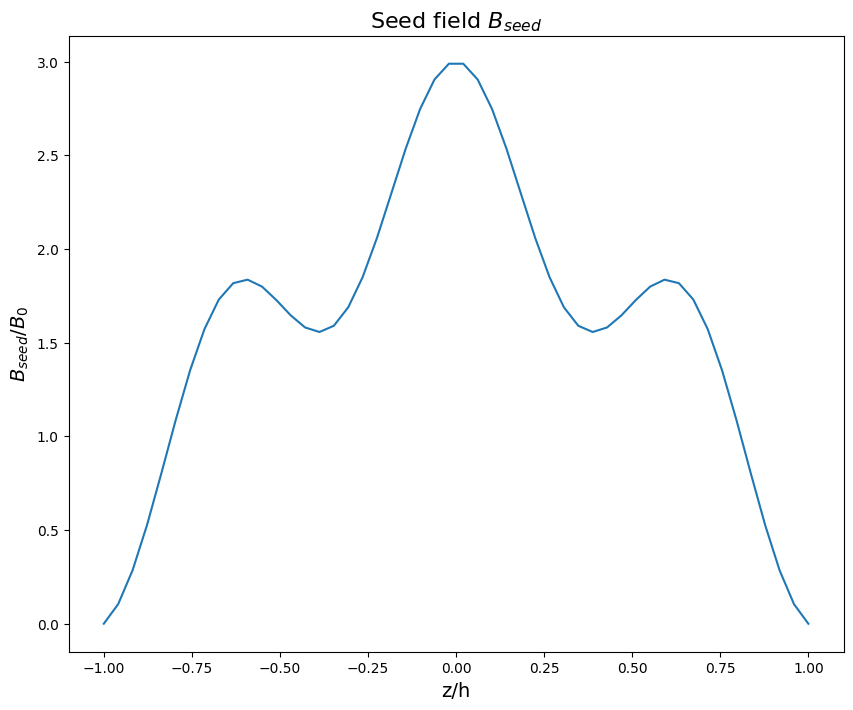

In [20]:
plt.figure(figsize=(10,8))
plt.plot(z, B2_sol_dir[0][0][0][0])
plt.xlabel('z/h', fontsize = 14)
plt.ylabel(r'$B_{seed}/B_0$', fontsize = 14)
plt.title('Seed field $B_{seed}$', fontsize = 16)
plt.savefig('images/B_seed_t2.png', bbox_inches='tight')
plt.show()
plt.close()

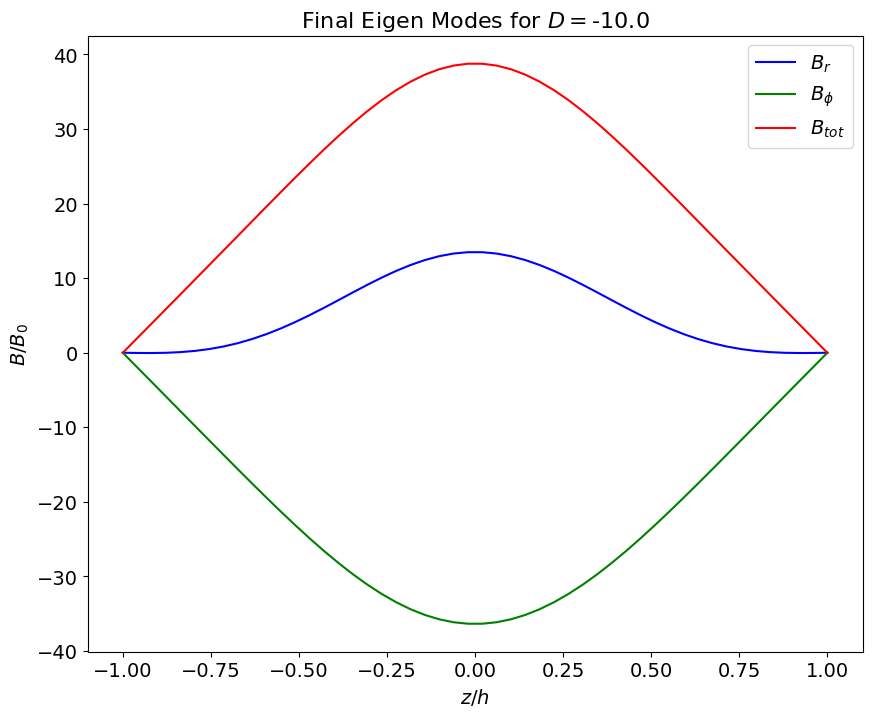

In [21]:
plot_final_magnetic_fields(z, B2_sol_dir[4], Romega_arr[4])


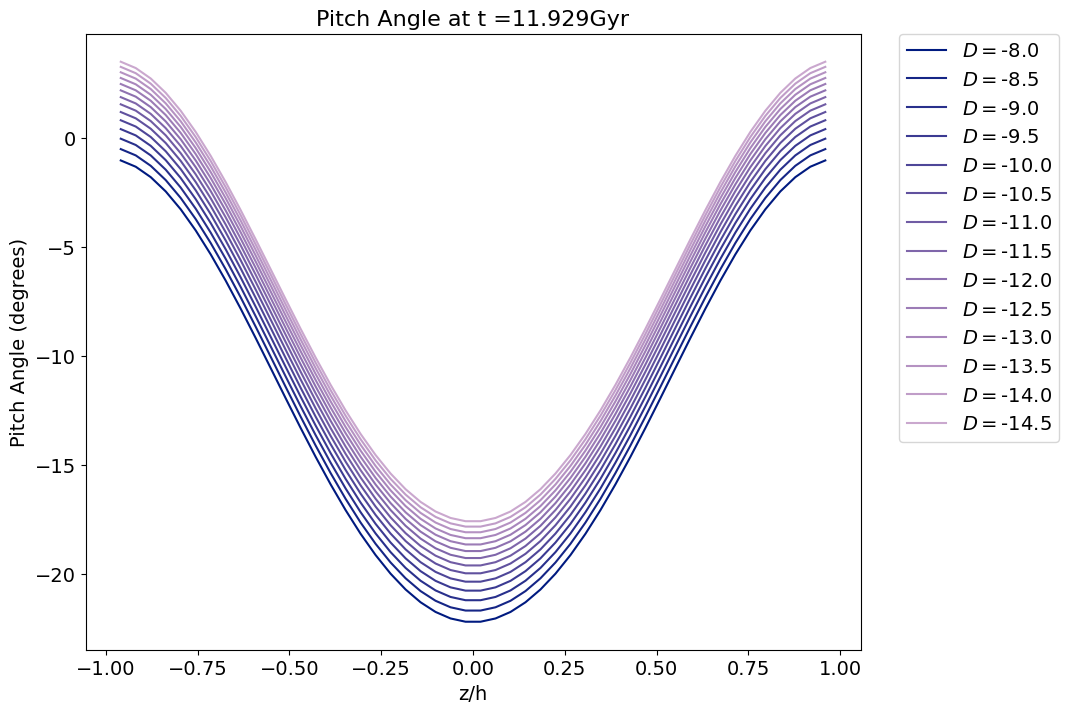

In [16]:
plt.figure(figsize = (10, 8))
for i in range(len(Romega_arr)):
    plt.plot(z[1:-1], pitch_angle_B2[i][-1]*180/np.pi, label = r'$D = $'+str(Romega_arr[i]), color = (round(i/(2*len(Romega_arr)), 5), 0.1, 0.5, round(1-i/(1.5*len(Romega_arr)), 5)))
plt.title(r'Pitch Angle at t ='+str(round(t[-1]*to_gyr, 3))+'Gyr', fontsize = 16)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., fontsize=14)
plt.tick_params(axis='x', labelsize=14)
plt.tick_params(axis='y', labelsize=14)
plt.xlabel('z/h', fontsize = 14)
plt.ylabel('Pitch Angle (degrees)', fontsize = 14)
plt.savefig('images/pitch_angle_t2.png', bbox_inches = 'tight')
plt.show()
plt.close()

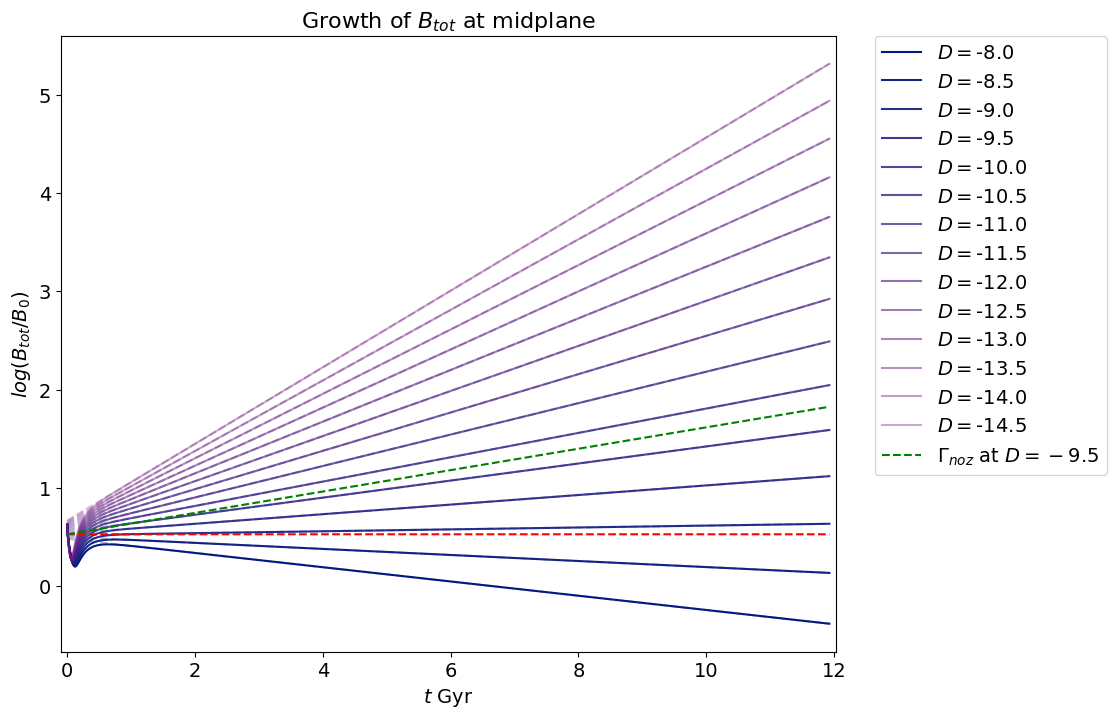

In [17]:
z_mid = len(z)//2
t0_index = np.where(t>2)[0][0]

fig, axs = plt.subplots(1, figsize = (10, 8))

for i in range(len(Romega_arr)):
    axs.plot(t*to_gyr, local_gamma_B2[i][z_mid-1]*(t - t[t0_index])+ np.log10(B2_total_dir[i][t0_index, z_mid]), color = (round(i/(2*len(Romega_arr)), 5), 0.1, 0.5, 0.3), linestyle = '--')
    axs.plot(t*to_gyr, np.log10(B2_total_dir[i][:,z_mid]), label = r'$D = $'+str(Romega_arr[i]), color = (round(i/(2*len(Romega_arr)), 5), 0.1, 0.5, round(1-i/(1.5*len(Romega_arr)), 5)))
plt.plot(t*to_gyr, np.repeat(np.log10(B2_total_dir[0][0, z_mid])-0.1, len(t)), color = 'r', linestyle = '--')
plt.plot(t*to_gyr, t*np.repeat(global_gamma_B_noz[3], len(t))+ np.repeat(np.log10(B2_total_dir[0][0, z_mid])-0.1, len(t)), label = r'$\Gamma_{noz}$ at $D=-9.5$', color = 'green', linestyle = '--')
axs.set_title(r'Growth of $B_{tot}$ at midplane', fontsize = 16)
axs.set_xlim(-0.1, to_gyr*t[-1]+0.1)
axs.tick_params(axis='x', labelsize=14)
axs.tick_params(axis='y', labelsize=14)
axs.set_xlabel(r'$t$ Gyr', fontsize=14)
axs.set_ylabel(r'$log(B_{tot}/B_0)$', fontsize=14)
axs.legend(fontsize=14, bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.savefig('images/B_growth_t2.png', bbox_inches = 'tight')
plt.show()
plt.close()


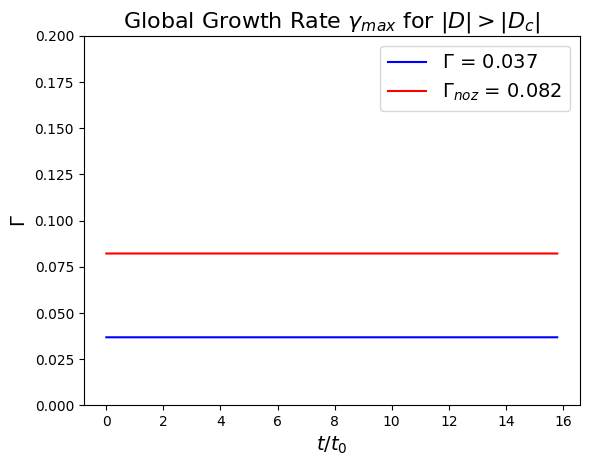

In [18]:
plt.plot(t, np.repeat(global_gamma_B2[3], len(t)), label = r'$\Gamma$ = '+str(round(global_gamma_B2[3], 3)), color = 'blue')
plt.plot(t, np.repeat(global_gamma_B_noz[3], len(t)), label = r'$\Gamma_{noz}$ = '+str(round(global_gamma_B_noz[3], 3)), color = 'red')
plt.title(r'Global Growth Rate $\gamma_{max}$ for $|D| > |D_c|$', fontsize = 16)
plt.ylim(0,0.2)
plt.xlabel(r'$t/t_0$', fontsize = 14)
plt.ylabel(r'$\Gamma$', fontsize = 14)
plt.legend(fontsize = 14)
plt.savefig('images/global_gamma_t2.png', bbox_inches = 'tight')
plt.show()
plt.close()